In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import librosa
from keras.utils import to_categorical

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [3]:
from sklearn.model_selection import train_test_split

def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def save_data_to_array(path, max_pad_len):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        x=0
        for wavfile in wavfiles:
            name=label+'_'+str(x)
            mfcc = wav2mfcc(wavfile, name, max_pad_len=max_pad_len)
            mfcc_vectors.append(mfcc)
            x=x+1
        np.save(label + '.npy', mfcc_vectors)
        
        
        
max_pad_len=30

def wav2mfcc(file_path, name, max_pad_len=30):
    wave, sr = librosa.load(file_path)
    mfcc = librosa.feature.melspectrogram(wave, sr=sr)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    pd.DataFrame(mfcc).to_csv(VALUE_PATH+'/'+name+'.csv')
    return mfcc

In [4]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\Dataset-v2'
VALUE_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\melspectrogramValues'


#db = r'C:\Users\lenovo_pc\Desktop\CNN_SR\SampleData'


# Second dimension of the feature is dim2
feature_dim_2 = 22

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 128
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [22]:

#X_train = np.array(x_train)
print(X_train.shape)
print(X_test.shape)


(224, 128, 22)
(57, 128, 22)


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [7]:
seq_length = 128

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(seq_length,30)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))


In [8]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
#model.fit(x_train, y_train, batch_size=7, epochs=10)

history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 224 samples, validate on 57 samples
Epoch 1/50
224/224 [==============================] - 15s 68ms/step - loss: 0.5982 - acc: 0.6562 - val_loss: 0.4284 - val_acc: 0.7895
Epoch 2/50
224/224 [==============================] - 12s 54ms/step - loss: 0.3778 - acc: 0.8482 - val_loss: 0.1638 - val_acc: 0.9825
Epoch 3/50
224/224 [==============================] - 15s 68ms/step - loss: 0.2068 - acc: 0.9621 - val_loss: 0.1088 - val_acc: 1.0000
Epoch 4/50
224/224 [==============================] - 18s 81ms/step - loss: 0.1387 - acc: 0.9799 - val_loss: 0.0815 - val_acc: 1.0000
Epoch 5/50
224/224 [==============================] - 16s 70ms/step - loss: 0.1180 - acc: 0.9888 - val_loss: 0.0607 - val_acc: 1.0000
Epoch 6/50
224/224 [==============================] - 17s 74ms/step - loss: 0.1080 - acc: 0.9888 - val_loss: 0.0457 - val_acc: 1.0000
Epoch 7/50
224/224 [==============================] - 14s 63ms/step - loss: 0.0672 - acc: 0.9978 - val_loss: 0.0321 - val_acc: 1.0000
Epoch 8/50
224/22

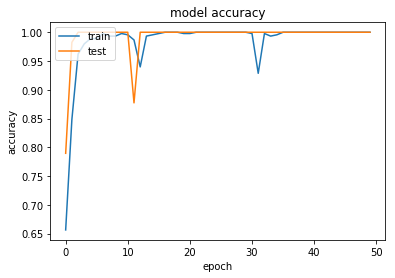

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


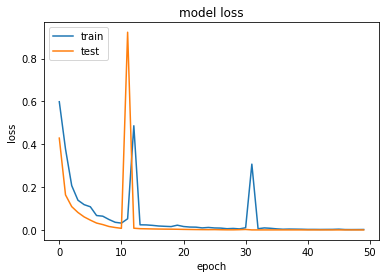

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
seq_length = 128

model = Sequential()
model.add(Conv1D(64, 4, activation='relu', input_shape=(seq_length,30)))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 2, activation='relu'))
model.add(Conv1D(256, 2, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [14]:

history = model.fit(X_train, y_train_hot, batch_size=7, epochs=10, validation_data=(X_test, y_test_hot))

Train on 224 samples, validate on 57 samples
Epoch 1/10
224/224 [==============================] - 39s 175ms/step - loss: 0.6263 - acc: 0.8237 - val_loss: 0.5114 - val_acc: 1.0000
Epoch 2/10
224/224 [==============================] - 40s 180ms/step - loss: 0.3749 - acc: 0.9933 - val_loss: 0.2085 - val_acc: 1.0000
Epoch 3/10
224/224 [==============================] - 41s 182ms/step - loss: 0.1773 - acc: 0.9955 - val_loss: 0.1005 - val_acc: 1.0000
Epoch 4/10
224/224 [==============================] - 39s 174ms/step - loss: 0.1125 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 1.0000
Epoch 5/10
224/224 [==============================] - 48s 214ms/step - loss: 0.0892 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 1.0000
Epoch 6/10
224/224 [==============================] - 47s 209ms/step - loss: 0.0770 - acc: 0.9978 - val_loss: 0.0414 - val_acc: 1.0000
Epoch 7/10
224/224 [==============================] - 57s 256ms/step - loss: 0.0680 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 8/10

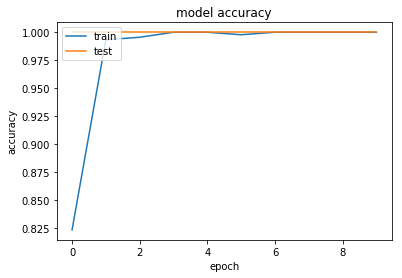

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

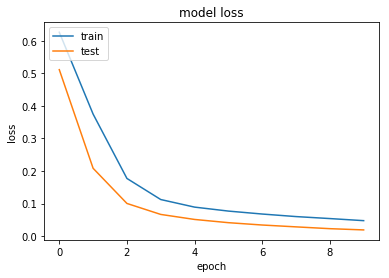

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [18]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (128,30)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           24320     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 36,802
Trainable params: 36,802
Non-trainable params: 0
_________________________________________________________________


In [19]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=50
MAX_BATCH=7

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_train, y_train_hot, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(X_test, y_test_hot),
                  callbacks=callback) 

print ("training finised!")




training started..... please wait.

Epoch 00001: loss improved from inf to 0.69135, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.69135 to 0.61298, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.61298 to 0.41398, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.41398 to 0.35103, saving model to ./best_model_trained.hdf5

Epoch 00005: loss improved from 0.35103 to 0.33514, saving model to ./best_model_trained.hdf5

Epoch 00006: loss improved from 0.33514 to 0.30277, saving model to ./best_model_trained.hdf5

Epoch 00007: loss improved from 0.30277 to 0.27145, saving model to ./best_model_trained.hdf5

Epoch 00008: loss improved from 0.27145 to 0.18757, saving model to ./best_model_trained.hdf5

Epoch 00009: loss improved from 0.18757 to 0.16186, saving model to ./best_model_trained.hdf5

Epoch 00010: loss did not improve from 0.16186

Epoch 00011: loss did not improve from 0.16186

Epoch 00012: loss

In [20]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")


model train data score       :  100.0 %
model test data score        :  100.0 %


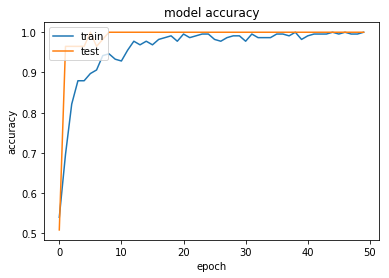

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

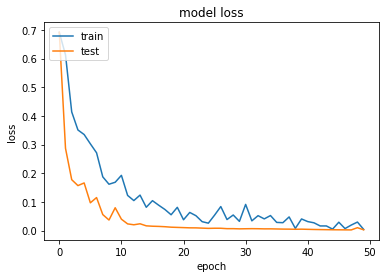

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()